In [10]:
from multiprocessing.pool import ThreadPool
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

# load the input image and grab the image dimensions
image = cv2.imread("C:\MajorProject\image_part_001 (22).png")
eighth = image.size // 8


orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

def find_bg():
    colors = {}
    colour = []
    temp = 0
    key = ""
    for i in range(H):
        for j in range(W):
            if str(image[i, j]) in colors:
                color = str(image[i, j])
                colors[color] += 1
                
                if temp < colors[color]:
                    temp = colors[color]
                    key = color
                    colour = image[i, j]
                if colors[color] == eighth:
                    temp = colors[color]
                    key = color
                    colour = image[i, j]
                    break         
            elif str(image[i, j]) not in colors:
                color = str(image[i, j])
                colors[color] = 1

    if temp == 0:
            for color in colors:
                if temp < colors[color]:
                    temp = colors[color]
                    key = color

    return colour

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

#start a thread to find the background color of the image
#while the bounding box rectangle coordinates are being determined
pool = ThreadPool(processes=1)
async_result = pool.apply_async(find_bg)
bg = async_result.get()


# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

start = time.time()
# loop over the number of rows
for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
                if scoresData[x] < 0.999:
                        continue

                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height of
                # the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
end = time.time()
print("[INFO] drawing the bounding boxes around text took {:.6f} seconds ".format(end - start))

start = time.time()        
# loop over the bounding boxes
for (startX, startY, endX, endY) in rects:
        box = [[[]]]
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        #area = abs((startX - endX) * (startY - endY))
        #bg = area // 4
        
        #set the colours of the pixels within and outlining the
        #bounding box to the background colour
        for i in range(startY, endY):
                for j in range(startX, endX):
                        orig[i,j] = bg
        start = time.time()
        '''for k in range(-5, 5):
            for l in range(len(rgb)):
                    rgb[l] = rgb[l] + k
            indices = np.where(box==rgb)
            orig[(indices[0]+startX), (indices[1]+startY), :] = [0, 0, 255]
            
        end = time.time()
        print(end-start)'''
        
        #draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

end = time.time()
print("[INFO] text removal took {:.6f} seconds ".format(end - start))

# show the output image
cv2.imshow("Text Removal", orig)
cv2.imwrite( 'out.jpg', orig)
cv2.waitKey(100)

[INFO] loading EAST text detector...
[INFO] text detection took 0.172333 seconds
[INFO] drawing the bounding boxes around text took 0.000000 seconds 
[INFO] text removal took 0.000000 seconds 


-1

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

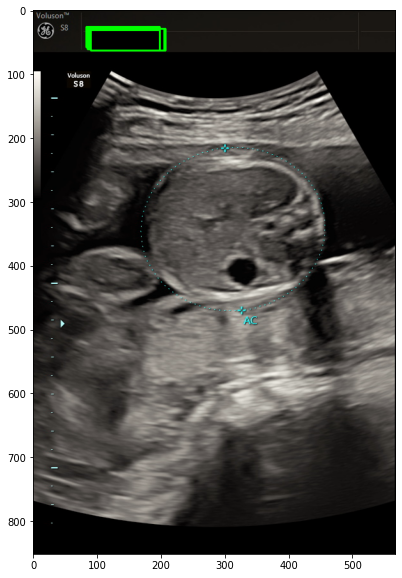

In [14]:
plt.figure(figsize=(12,10))
plt.imshow(orig)

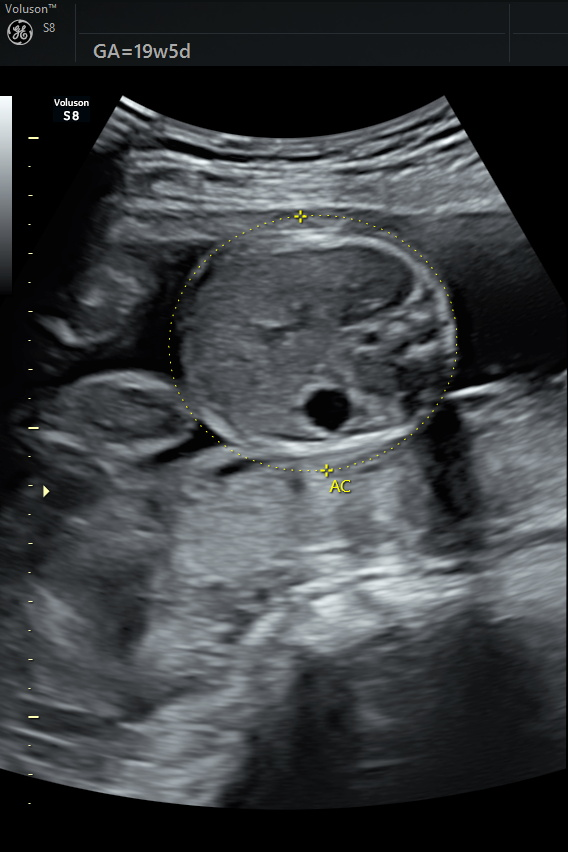

In [15]:
Image.open("C:\MajorProject\image_part_001 (22).png")